# Поиск наиболее похожих товаров

## Введение

Заказчик предоставил анонимизированный набор имеющихся на складах товаров и набор новых товаров, для которых необходимо найти наиболее похожие из имеющегося набора. 
Особенность задачи состоит в том, что автоматический подбор похожих товаров должен производиться так, чтобы симулировать работу экспертов. Образцы их ответов предоставлены для обучения модели в отдельном файле вместе с примерами запросов.

## Описание данных

- <u>base.csv</u> - анонимизированный **набор товаров**. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- <u>train.csv</u> - **обучающий датасет**. Каждая строчка - один товар, для которого известен уникальный id (0-query, …, 100000-query), вектор признаков и id товара из base.csv, который максимально похож на него по мнению экспертов.

- <u>validation.csv</u> - **датасет с товарами** (уникальный id и вектор признаков), **для которых надо найти наиболее близкие** товары из base.csv.

- <u>validation_answer.csv</u> - **правильные ответы** к датасету с товарами для поиска (даётся **для оценки** работы простроенной **модели**).


## Задачи

- **разработать алгоритм**, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.csv;
- **оценить качество алгоритма** по метрике **accuracy@5**.

## Вывод

1. В рамках исследования были представлены 3 набора данных:
- Пропусков и дубликатов нет ни в одном наборе.
- Данные в основном представлены непрерывными числовыми значениями, основная их доля очевидно имеет нормальное распределение. 
- Данные, которые явно не характеризуются нормальным распределением были исключены из анализа, т.к. такие данные вносят лишние шумы.
- Сильных корреляционных зависимостей не выявлено.

2. Учитывая тот факт, что формула для расчёта расстояния между точками в пространстве чувствительна к диапазону значений различных характеристик, данные были нормализованы.

3. Дополнительно проанализирована целевая метрика в зависимости от количества кандидатов в диапозоне от 5 до 500 кандадатов и установлено:
- с увеличением количества кандидатов растет и максимальное значение целевой метрики
- увеличение количества кандидатов увеличит и время предсказания модели, так как ей придется в каждой иттерации просчитывать бОльшее количество кандидатов.

4. Для решения поставленной задачи было создано и наполнено векторное пространство из объектов анонамизированного набора данных (base). Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из train были найдены 10 ближайших векторов при помощи меры FlatL2 (при большом количестве не хватало оперативной памяти при формировании дататсетов для обучения и тестирования ML модели).

5. На тренировочном датасете (train) получаем значение метрики **accuracy@5=63.114**, что является удовлетворительным результатом работы модели. Такой результат удалось достичь за счет удалениея не информативных признаков и стандартизации данных. При этом на тестовой выборке (validation) значение метрики **accuracy@5= 62.96** достигнуто без учета ранжирования ML моделью.

6. В качестве ML модели был выбран CatBoostClassifier и проведен подбор гиперпараметров. По обученной модели пердсказаны вероятности совместимости и по найденным занчениям вероятностей  определены 5 наиболее подходящих кандидато по которым расчитано значение целевой метрики **accuracy@5=61.81**

**На текущем этапе мы видим, что применение ML модели не улучшает показатель целевой метрики, тем не менее в дальнейшем можно поробовать усовершенстовать модель и повторно сравнить результат**

## Импорт библиотек

In [1]:
!pip install faiss-cpu --no-cache

In [2]:
!pip install catboost

In [3]:
!pip install optuna

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import faiss
import optuna
import datetime as dt

#from adjdatatools.preprocessing import AdjustedScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, f1_score, roc_curve
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
RANDOM_STATE = 12345

# Загрузка и анализ данных

In [5]:
# функция для предварительного знакомства с данными
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [6]:
# открываем файл с анонимизированным набором товаров 
df_base = pd.read_csv("base.csv", index_col=0)
df_train = pd.read_csv("train.csv", index_col=0)
df_validation = pd.read_csv("validation.csv", index_col=0)
df_validation_answer = pd.read_csv("validation_answer.csv", index_col=0)

## Анонимизированный набор товаров

In [7]:
first_look(df_base)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39 

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

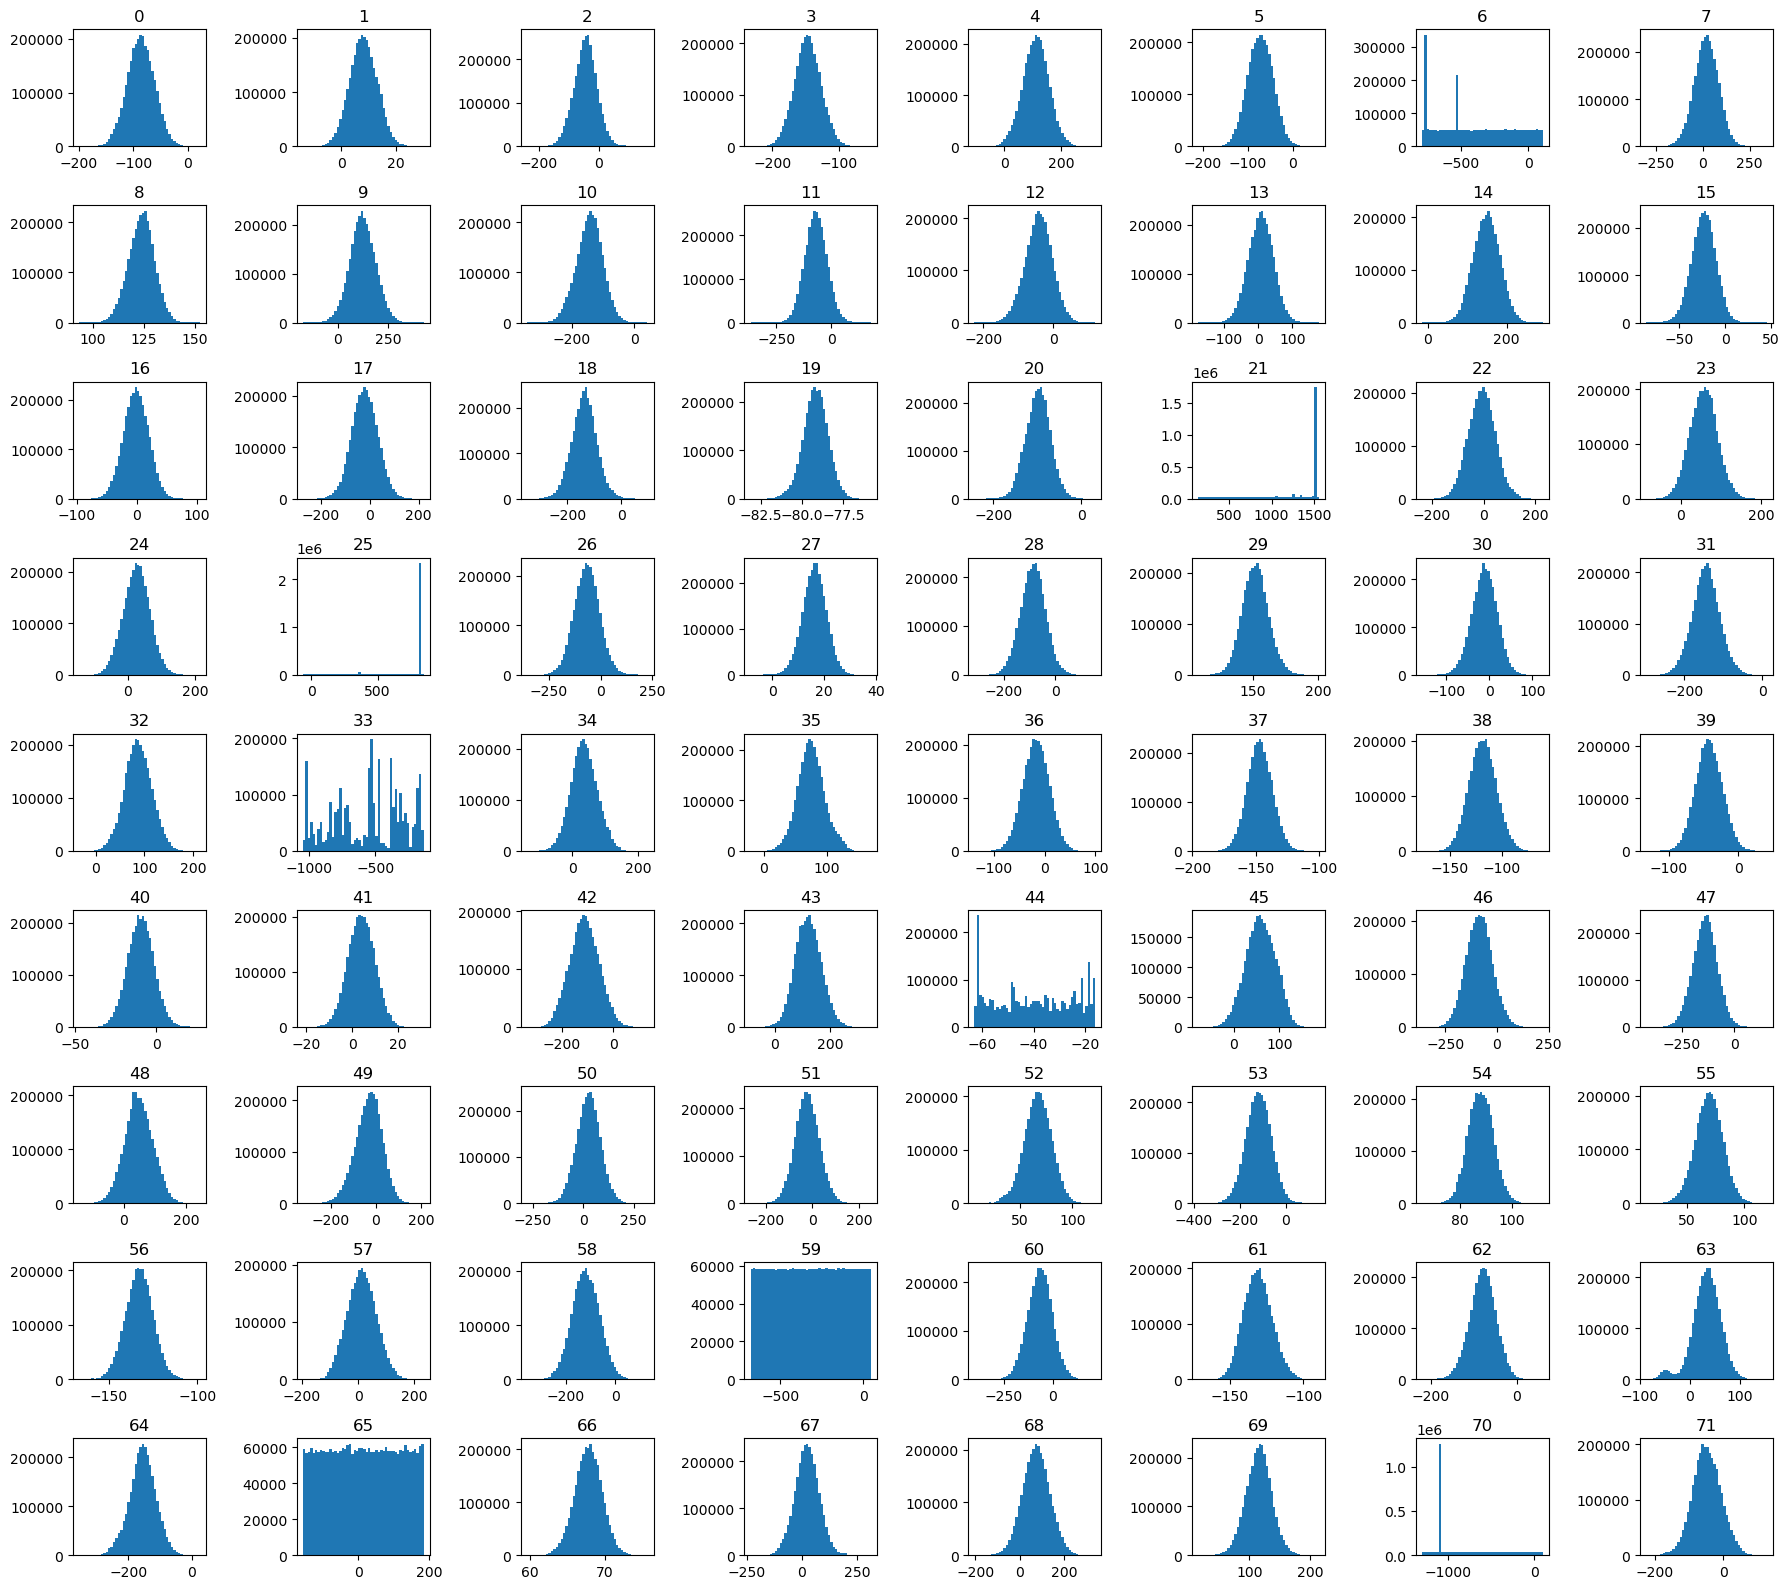

In [8]:
df_base.hist(figsize=(18, 16), bins=50, grid=False);
plt.tight_layout()
plt.show()

In [9]:
df_base = df_base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

**Вывод**
- Набор товаров, среди которых нам нужно проводить поиск содержит почти 3 млн образцов
- Данные зашифрованы. Для каждого образца товара имеется 72 характеристики все представляют собой дробные числа
- Пропусков и дубликатов в наборе нет
- Как видно из гистограмм, большинство признаков имеют бликое к нормальному распределению. Но имеются признаки никак не связанные с нормальным распределением. В первой иттерации удалим эти признаки.

## Данные, для которых даны оценки экспертов

In [10]:
first_look(df_train)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Количество пропусков:
0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

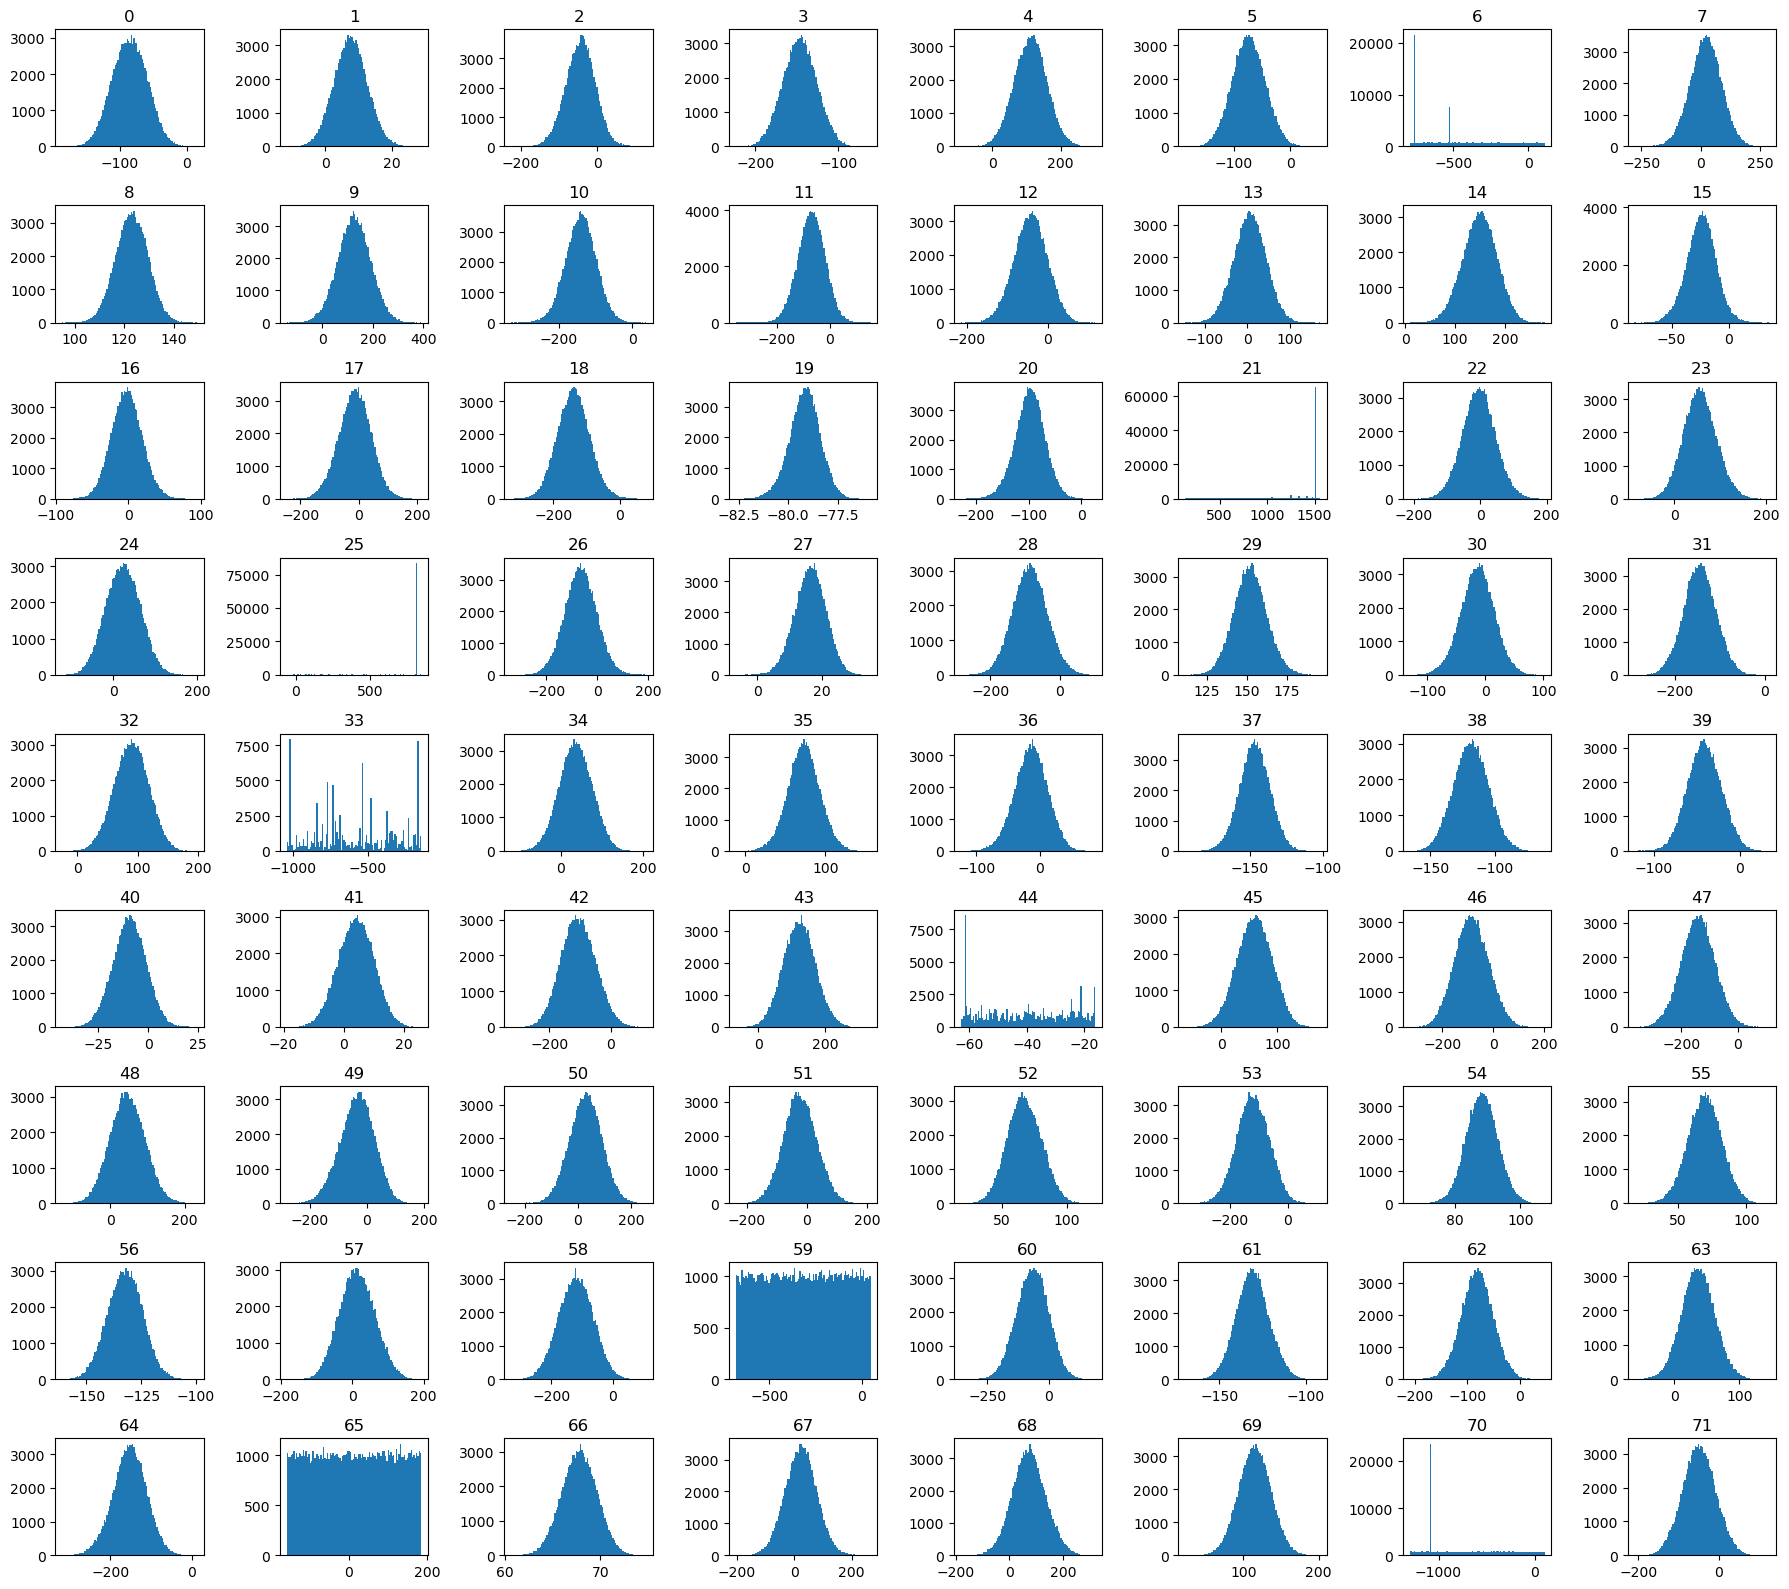

In [11]:
df_train.hist(figsize=(18, 16), bins=100, grid=False);
plt.tight_layout()
plt.show()

**Вывод**
- Данные, для которых даны оценки экспертов без пропусков и дубликатов
- Характеристики имеют те же распределения, что и в базовом датасете. Также удалим признаки
- Оценки экспертов содержатся в отдельном столбце target. Выделим его в отдельную переменную для последующей передачи модели.

In [12]:
# разделим запросы и ответы экспертов
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [13]:
df_train = df_train.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

## Данные для проверки качества модели

In [14]:
first_look(df_validation)

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-

None

Первые 5 строк(и) данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Основные статистические характеристики данных


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


Количество пропусков:
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Количество дубликатов: 0


Посмотрим на распределение значений признаков.

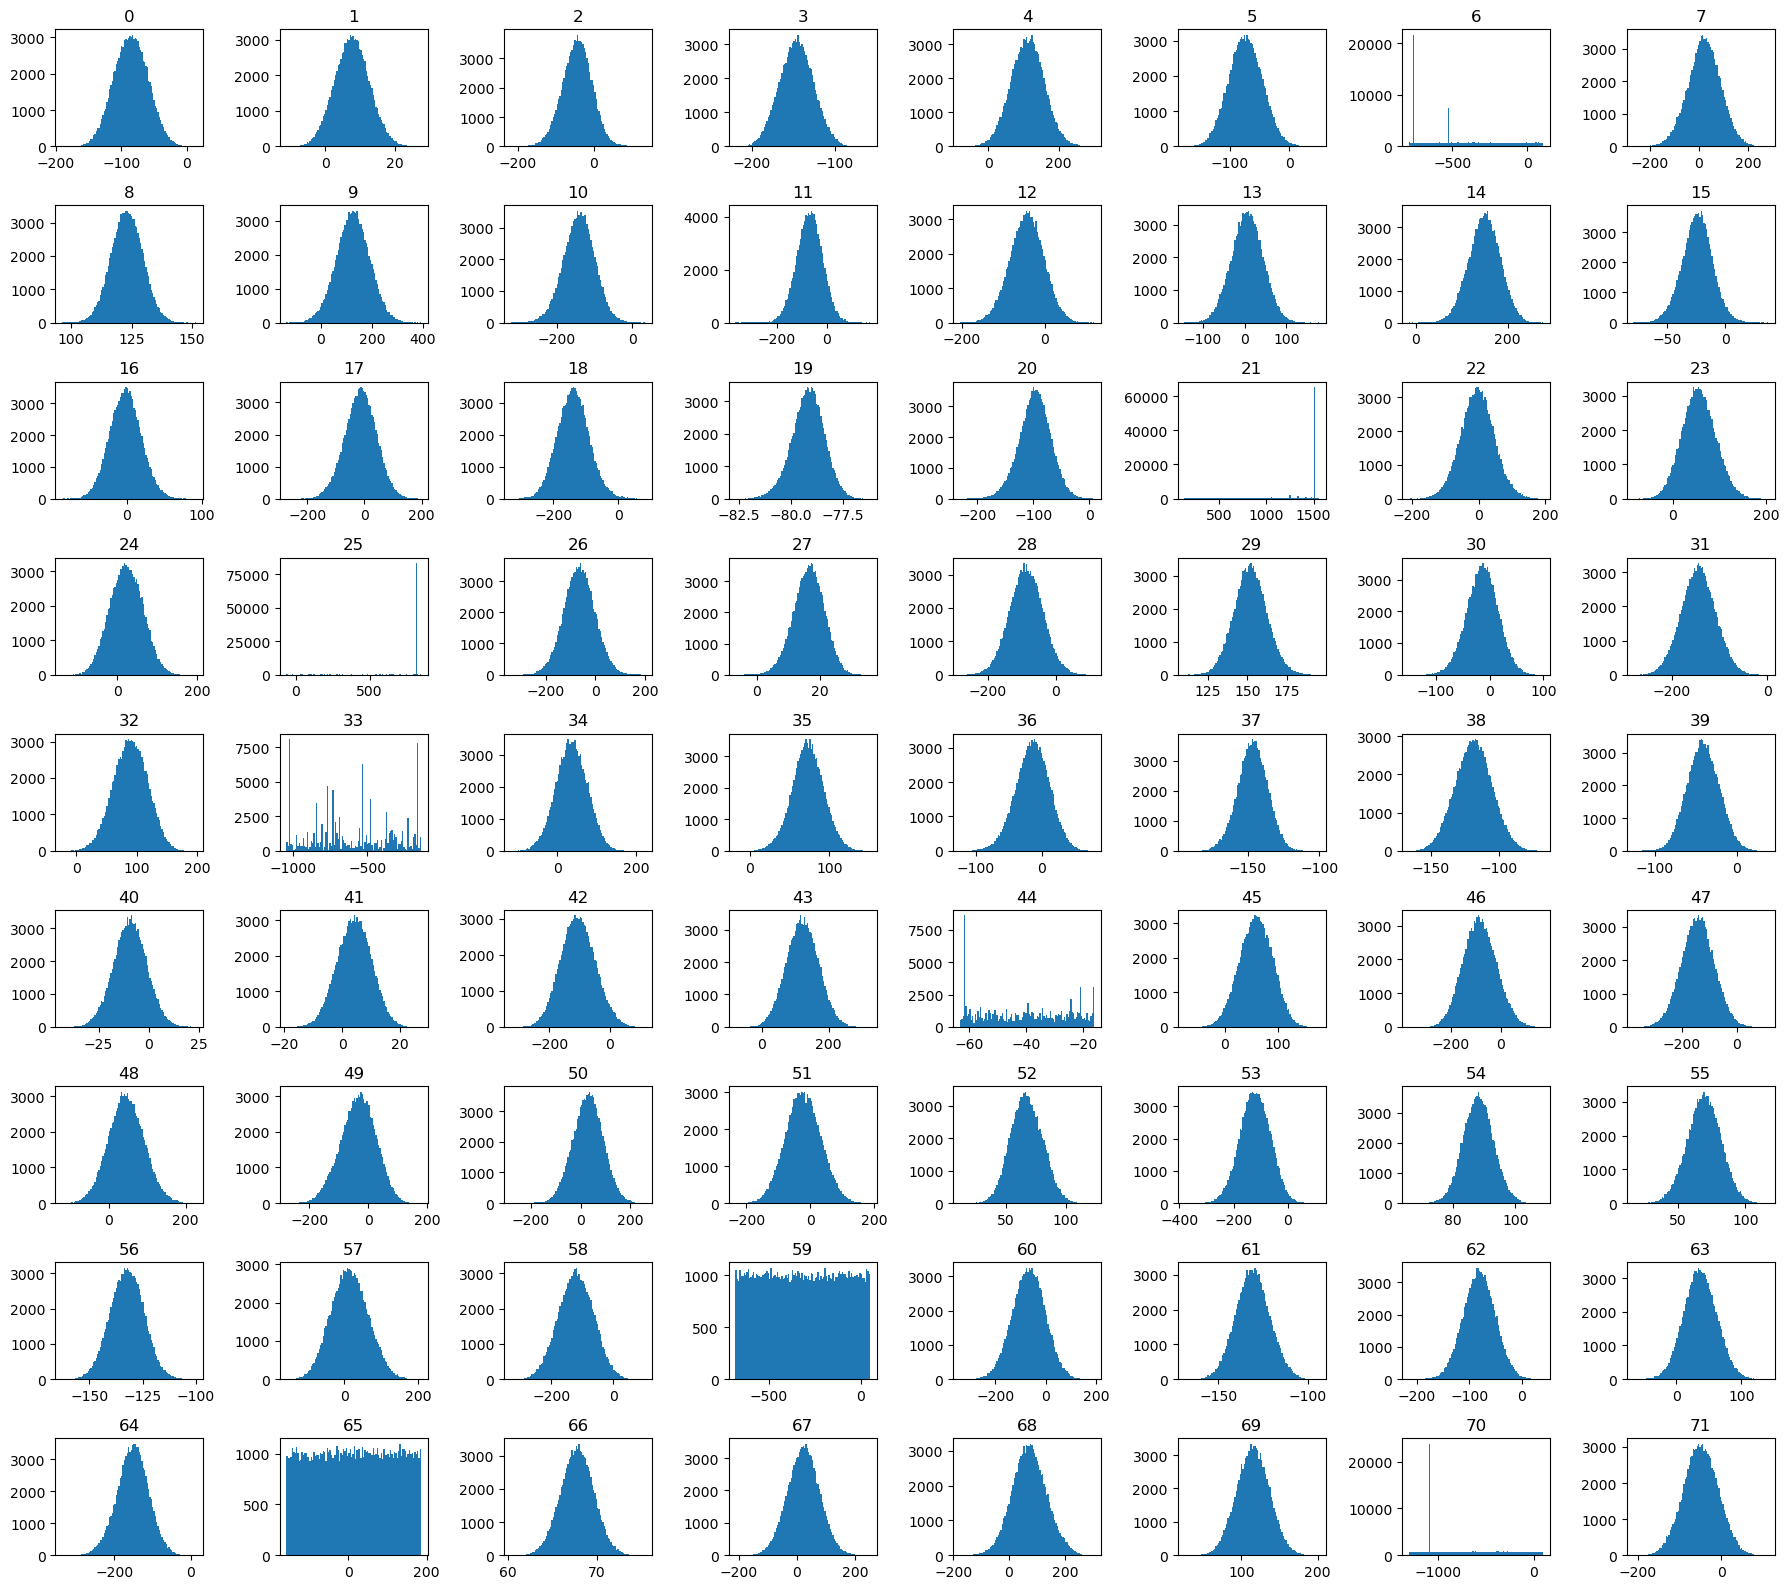

In [15]:
df_validation.hist(figsize=(18, 16), bins=100, grid=False);
plt.tight_layout()
plt.show()

**Выводы** для датасета с запросами, для которых необходимо подобрать похожие товары в соответствии с рекомендациями экспертов аналогичны предидущему датасету.

In [16]:
df_validation = df_validation.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

## Корреляция на базе анонимизированного набора товаров

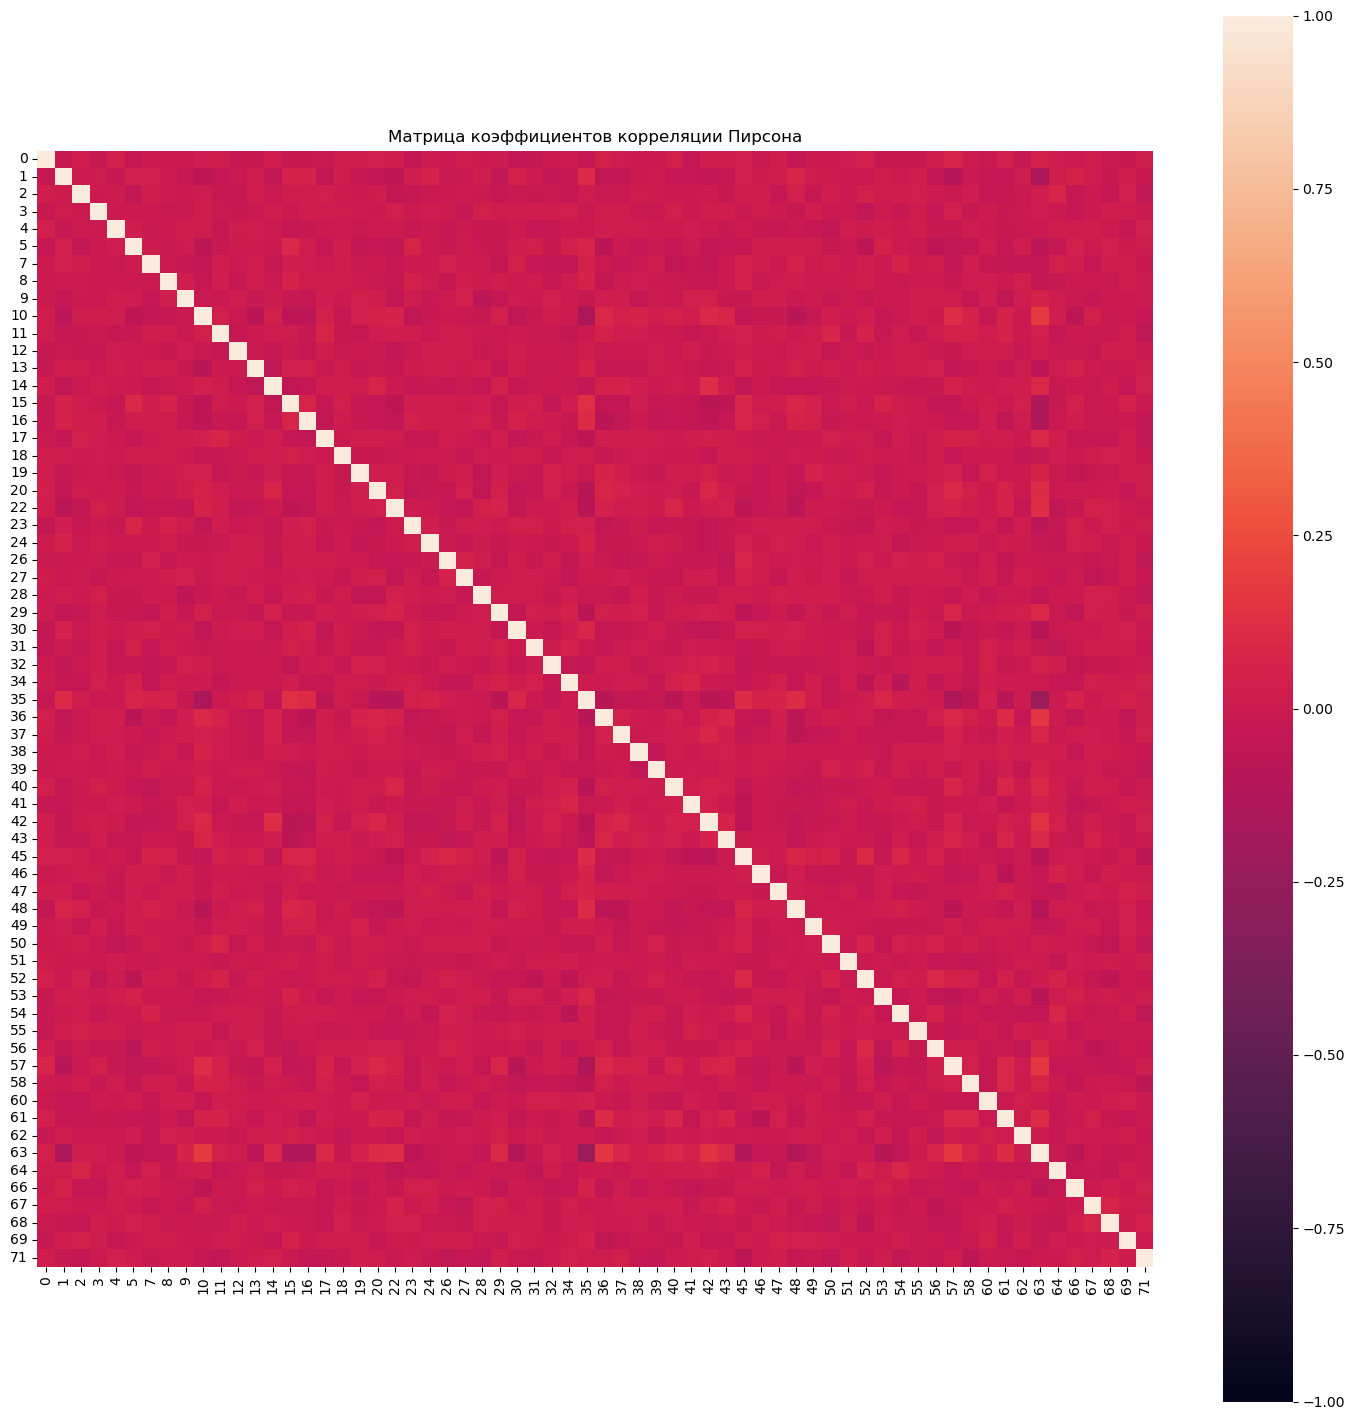

In [17]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_base.corr(), vmin=-1, vmax=1, square=True, annot=False, fmt='.2f');
plt.title('Матрица коэффициентов корреляции Пирсона')
plt.show()

## Вывод после предварительного знакомства с данными

Для исследования доступны три набора данных
- 3 млн товаров, среди которых мы должны подбирать похожие на входные запросы
- 100 000 строк запросов с ответами экспертов
- 100 000 запросов для подбора похожих товаров с помощью разрабатываемой модели.

Все три набора данных зашифрованы Для каждого образца товара имеется 72 характеристики все представляют собой дробные числа. 

Пропусков и дубликатов нет ни в одном наборе.

Данные в основном представлены непрерывными числовыми значениями, основная их доля очевидно имеет нормальное распределение. Те данные, которые явно не характеризуются нормальным распределением, будут вносить лишний шум в результаты метчинга - такие данные исклчюены.

Сильных корреляционных зависимостей не наблюдается.


# Нормализация данных

Так как формула для расчёта расстояния между точками в пространстве чувствительна к диапазону значений различных характеристик, предварительно нормализуем данные.


In [18]:
scaler = StandardScaler()
scaler.fit(df_base[df_base.columns])
df_base[df_base.columns]             = scaler.transform(df_base[df_base.columns])
df_train[df_train.columns]           = scaler.transform(df_train[df_train.columns])
df_validation[df_validation.columns] = scaler.transform(df_validation[df_validation.columns])

# Поиск ближайших соседей

Для того, чтобы найти в базовом наборе товары, похожие на наш запрос, воспользуемся библиотекой FAISS.

Принцип работы Faiss:
- Отображение всех объектов (векторов) в едином пространстве
- Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
- Для каждого кластера происходит поиск его центра (центроида)
- Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
- После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

FlatL2 - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость. quantizer - квантизатор, который получает на вход вектора размерностью dims и рассчитывает расстояние между ними по евклидовой норме. idx_l2 - пространство векторов размерностью dims, разделяемое на n_cells кластеров с помощью quantizer.

In [19]:
# инициализация индекса
dims = df_base.shape[1]
n_cells = 18
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [20]:
# подготовка к поиску
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

# создание словаря для нахождения индекса товара в базовом наборе данных
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Далее расчитана целевая метрика в зависимости от количества кандидатов. По заданию метрика считается для 5 кандидатов, но ml модель может немного улучшить метрику. Ислледуем диапозон от 5 до 450 кандадатов

In [21]:
cand_number = []
cand_result = []

for i in range(5, 450, 50):
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), i)
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    cand_number.append(i)
    cand_result.append(100 * acc / len(idx))

In [22]:
test_cand = pd.DataFrame({'num_candidate': cand_number, 'acc': cand_result})

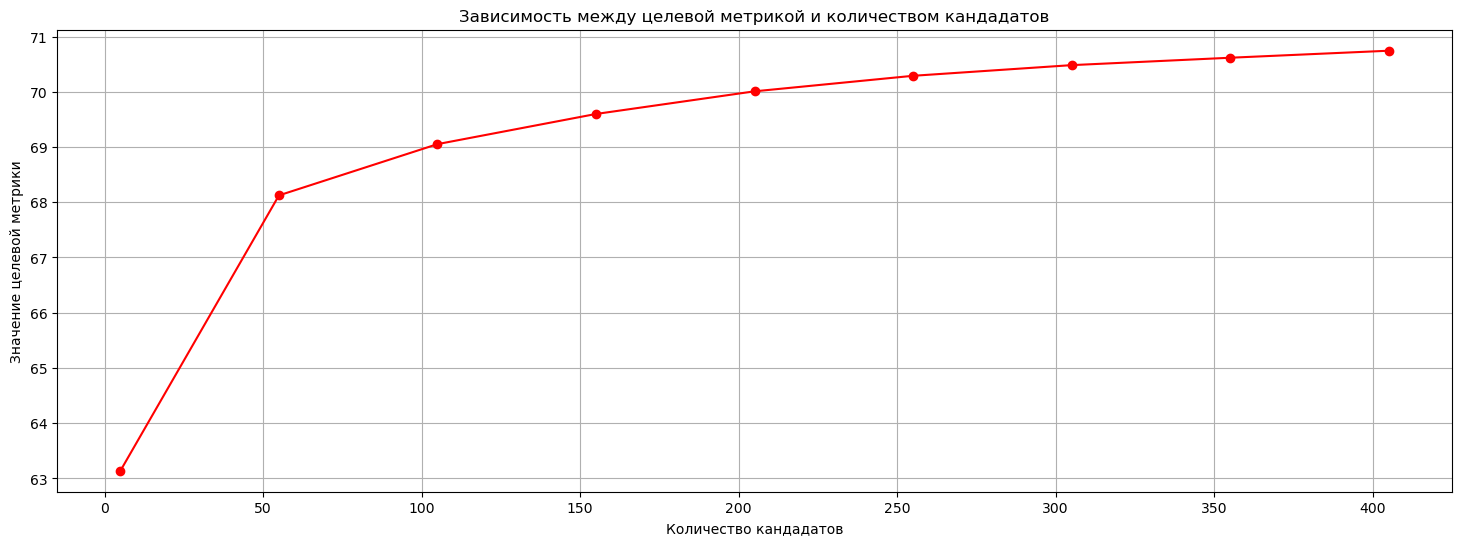

In [23]:
plt.figure(figsize=(18, 6))
plt.plot(test_cand.num_candidate, test_cand.acc, 'ro-')
plt.grid(True)
plt.title('Зависимость между целевой метрикой и количеством кандадатов')
plt.ylabel('Значение целевой метрики')
plt.xlabel('Количество кандадатов')
plt.show()

Как видно, с увеличением метрики растетм и максимальное значение целевой метрики. Но нужно понимать, что увеличение количества кандидатов увеличит и время предсказания модели, так как ей придется в каждой иттерации просчитывать бОльшее количество кандидатов. В данном случае необходимо найти баланс между количеством кандидатов и затрачиваемого времени. В первом приближении предлагается использовать 20 кандидатов - значение целевой метрики около 67%.

## Поиск по обучающей выборке

In [24]:
K_NEIGHBORS = 10

Проводим сопоставление товаров библиотекой Faiss, для получения результата по метрике accuracy@5 задаем подбор 5 кандидатов.

In [25]:
# измерим время поиска
start_time = dt.datetime.now().timestamp()
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), K_NEIGHBORS)
time_spent = dt.datetime.now().timestamp() - start_time
print(f'Время поиска: {time_spent // 60} минут и {time_spent % 60} секунд')

Время поиска: 3.0 минут и 51.524460792541504 секунд


Считаем метрику на тренировочном датасете.

In [26]:
acc_n = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_n += int(target in [base_index[r] for r in el])
print(100 * acc_n / len(idx))

64.963


In [27]:
acc_5 = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_5 += int(target in [base_index[r] for r in el[:5]])
print(100 * acc_5 / len(idx))

63.139


На текущему этапе создано и наполнено векторное пространство из объектов датасета base. Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из train были найдены 10 ближайших векторов при помощи меры FlatL2. На тренировочном датасете получаем значение метрики **accuracy@5=63.139**, что является удовлетворительным результатом работы модели. Такой результат удалось достичь за счет удаления не информативных признаков и стандартизации данных. Для 10 кандадатов значение метрики **accuracy@30=64.963**. Далее, среди найденных кандидатов необходимо выявить самые подходящие. Для этого их требуется отранжировать.

**p.s. свыше 10 кандидатов проверить не удалось - ругается на нехватку оперативной памяти.**

# Ранжирование

## Формирование тренировочной выборки

Првым шагом необходимо составить новый датафрейм состоящий из двух половин:

Искомые векторы
Несколько кандидатов на сопоставление для каждого искомого вектора.
Последним столбцом для этого вектора станет matching содержащий правильный ответ: 1 - вектор подходит, 0 - вектор не подходим.

In [28]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(dtype='float32', data=idx, index=df_train.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

idx_df

,id_query,id_candidate
0,0-query,361564-base
1,0-query,1375561-base
2,0-query,2515747-base
3,0-query,530165-base
4,0-query,244376-base
...,...,...
999995,99999-query,2646872-base
999996,99999-query,1137584-base
999997,99999-query,707395-base
999998,99999-query,990986-base


Полученные колонки с id товаров будут использованы для объединения при помощи метода merge(). В качестве данных будут использоваться уже отмасштабированные признаки

In [29]:
df_train_base = idx_df.merge(df_train, left_on='id_query', right_on='Id', how='left')
df_train_base = df_train_base.merge(df_base, left_on='id_candidate', right_on='Id', how='left', suffixes=('', '_base'))
df_train_base = df_train_base.merge(targets, left_on='id_query', right_on='Id', how='left')

df_train_base.head()

,id_query,id_candidate,0,1,2,3,4,5,7,8,...,61_base,62_base,63_base,64_base,66_base,67_base,68_base,69_base,71_base,Target
0,0-query,361564-base,1.299519,1.996888,0.063774,-1.879671,1.6441,-0.537626,0.279598,-2.296794,...,0.216622,-0.332150,1.723392,-0.369458,-1.100241,0.280916,-0.492041,0.532096,0.090279,675816-base
1,0-query,1375561-base,1.299519,1.996888,0.063774,-1.879671,1.6441,-0.537626,0.279598,-2.296794,...,0.144494,-0.873146,1.699855,-0.241953,-0.985260,0.009024,-0.475138,0.479394,0.371489,675816-base
2,0-query,2515747-base,1.299519,1.996888,0.063774,-1.879671,1.6441,-0.537626,0.279598,-2.296794,...,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024,675816-base
3,0-query,530165-base,1.299519,1.996888,0.063774,-1.879671,1.6441,-0.537626,0.279598,-2.296794,...,0.235214,-0.795015,1.797431,-0.348638,-1.220349,0.203649,-0.711434,0.745986,0.805135,675816-base
4,0-query,244376-base,1.299519,1.996888,0.063774,-1.879671,1.6441,-0.537626,0.279598,-2.296794,...,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648,675816-base


In [30]:
# преобразование целевого признака для бинарной классификации
df_train_base['matching'] = (df_train_base['id_candidate'] == df_train_base['Target']).astype('int')
df_train_base.drop('Target', axis=1, inplace=True)

C:\Users\Serge\AppData\Local\Temp\ipykernel_14600\3317088504.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_base['matching'] = (df_train_base['id_candidate'] == df_train_base['Target']).astype('int')


In [31]:
# выделение признаков и таргета
y_train = df_train_base['matching']
X_train = df_train_base.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
999995,0
999996,0
999997,0
999998,0


,0,1,2,3,4,5,7,8,9,10,...,60_base,61_base,62_base,63_base,64_base,66_base,67_base,68_base,69_base,71_base
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.414040,0.216622,-0.332150,1.723392,-0.369458,-1.100241,0.280916,-0.492041,0.532096,0.090279
1,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.685312,0.144494,-0.873146,1.699855,-0.241953,-0.985260,0.009024,-0.475138,0.479394,0.371489
2,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.367851,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024
3,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.562718,0.235214,-0.795015,1.797431,-0.348638,-1.220349,0.203649,-0.711434,0.745986,0.805135
4,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.384374,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902251,-0.794043,-0.111113,...,0.035901,-0.837638,1.508795,-2.567009,0.834703,0.779250,1.071996,-0.076514,-1.302187,-0.285297
999996,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902251,-0.794043,-0.111113,...,0.826323,-1.622951,-0.452213,-1.149084,0.640818,0.029353,0.043526,1.567201,-0.018664,-0.511889
999997,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902251,-0.794043,-0.111113,...,1.565252,-1.140709,-0.153356,-1.412175,0.473385,0.700582,0.607596,0.401012,0.934545,-0.970575
999998,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902251,-0.794043,-0.111113,...,-0.756739,-1.929538,-0.343843,-1.319255,1.352338,-0.376322,-1.158844,1.999483,-2.321207,-0.790917


В результате получилась выборка для обучения:
- 1 000 000  записей = 100 000 новых товаров (query) * 10 ближайших кандидатов для каждого.
- 128 признака = 64 признака "старых" товаров из base + 64 признака "новых" товаров из train.
- бинарный целевой признак.

## Поиск по тестовой выборке

In [32]:
# поиск ближайших соседей для валидационной выборки
start_time = dt.datetime.now().timestamp()
valid_vec, valid_idx = idx_l2.search(np.ascontiguousarray(df_validation), K_NEIGHBORS)
time_spent = dt.datetime.now().timestamp() - start_time
print(f'Время поиска: {time_spent // 60} минут и {time_spent % 60} секунд')

Время поиска: 3.0 минут и 54.68569087982178 секунд


In [33]:
acc_n_valid = 0

for target, el in zip(df_validation_answer['Expected'].values.tolist(), valid_idx.tolist()):
    acc_n_valid += int(target in [base_index[r] for r in el])

print(100 * acc_n_valid / len(valid_idx))

64.767


In [34]:
acc_5_valid = 0

for target, el in zip(df_validation_answer['Expected'].values.tolist(), valid_idx.tolist()):
    acc_5_valid += int(target in [base_index[r] for r in el[:5]])

print(100 * acc_5_valid / len(valid_idx))

62.989


Результата на тестовой выборке (без ранжирования ML моделью) составялет 62.99, что весьма неплохо. Темне-менее попробуем улчишть с применением ML.

## Формирование тестовой выборки

Аналогичную процедуру  как и для обучающей выборки необходимо выполнить для тестовой выборки.

In [35]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(dtype='float32', data=valid_idx, index=df_validation.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,100000-query,2760762-base
1,100000-query,3209652-base
2,100000-query,1542803-base
3,100000-query,3839597-base
4,100000-query,508555-base
...,...,...
999995,199999-query,3405693-base
999996,199999-query,245294-base
999997,199999-query,495492-base
999998,199999-query,246186-base


In [36]:
df_valid_base = idx_df.merge(df_validation, left_on='id_query', right_on='Id', how='left')
df_valid_base = df_valid_base.merge(df_base, left_on='id_candidate', right_on='Id', how='left', suffixes=('', '_base'))
df_valid_base = df_valid_base.merge(df_validation_answer, left_on='id_query', right_on='Id', how='left')

df_valid_base.head()

,id_query,id_candidate,0,1,2,3,4,5,7,8,...,61_base,62_base,63_base,64_base,66_base,67_base,68_base,69_base,71_base,Expected
0,100000-query,2760762-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162421,-1.245106,2676668-base
1,100000-query,3209652-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.929758,0.457506,0.948873,0.570802,0.909867,0.897679,0.018913,0.430446,-1.182590,2676668-base
2,100000-query,1542803-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.539853,0.112325,0.345714,0.193005,0.721657,0.610940,-0.160718,0.507207,-1.025508,2676668-base
3,100000-query,3839597-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.979324,0.247559,0.610572,-0.253008,0.633810,0.570935,-0.031723,0.628662,-1.195790,2676668-base
4,100000-query,508555-base,1.15931,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.859636,0.304084,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531,2676668-base


In [37]:
# преобразование целевого признака для бинарной классификации
df_valid_base['matching'] = (df_valid_base['id_candidate'] == df_valid_base['Expected']).astype('int')
display(df_valid_base[['id_query', 'id_candidate', 'Expected', 'matching']])
df_valid_base.drop('Expected', axis=1, inplace=True)

C:\Users\Serge\AppData\Local\Temp\ipykernel_14600\1150914390.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid_base['matching'] = (df_valid_base['id_candidate'] == df_valid_base['Expected']).astype('int')


,id_query,id_candidate,Expected,matching
0,100000-query,2760762-base,2676668-base,0
1,100000-query,3209652-base,2676668-base,0
2,100000-query,1542803-base,2676668-base,0
3,100000-query,3839597-base,2676668-base,0
4,100000-query,508555-base,2676668-base,0
...,...,...,...,...
999995,199999-query,3405693-base,336472-base,0
999996,199999-query,245294-base,336472-base,0
999997,199999-query,495492-base,336472-base,0
999998,199999-query,246186-base,336472-base,0


In [38]:
# выделение признаков и таргета
y_valid = df_valid_base['matching']
X_valid = df_valid_base.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
999995,0
999996,0
999997,0
999998,0


,0,1,2,3,4,5,7,8,9,10,...,60_base,61_base,62_base,63_base,64_base,66_base,67_base,68_base,69_base,71_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.511698,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162421,-1.245106
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.655191,-1.929758,0.457506,0.948873,0.570802,0.909867,0.897679,0.018913,0.430446,-1.182590
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.979234,-1.539853,0.112325,0.345714,0.193005,0.721657,0.610940,-0.160718,0.507207,-1.025508
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.608282,-1.979324,0.247559,0.610572,-0.253008,0.633810,0.570935,-0.031723,0.628662,-1.195790
4,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.380106,-1.859636,0.304084,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,1.172158,1.056181,-1.892759,-0.181102,-0.038931,-0.308994,-0.720239,1.504732,1.111104,-1.404785
999996,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,1.833956,1.046895,-0.892144,-0.154685,0.215508,-0.335107,-0.243209,0.792508,0.672011,-0.815363
999997,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,0.655818,0.847917,-0.776124,0.711916,-0.653749,-0.385602,-0.171102,0.868847,1.366987,-0.099685
999998,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,1.298883,1.022316,-1.248087,-0.074081,0.086405,-0.279040,-0.777847,0.740038,1.075700,-0.814948


## Обучение ML-модели

In [39]:
y_train.value_counts(normalize=True)

matching
0    0.935037
1    0.064963
Name: proportion, dtype: float64

Обучать будем CatBoostClassifier. Для подготовки модели осталось получить лучшие гиперпараметры. Предлагается воспользоваться библиотекой Optuna.В качестве метрики выбрана F1, так как в отличии от accuracy дисбаланс классов на нее не влияет, а у нас наблюдается сильный дисбаланс.

In [40]:
def objective(trial: optuna.Trial):
    params = {
            'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1, step=0.0001),
            'depth': trial.suggest_int('depth', 2, 10, step=1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True)
    }
    
    cbc = CatBoostClassifier(**params, random_state=RANDOM_STATE, verbose=False)
    cv = KFold(n_splits=4)
    scorer = make_scorer(f1_score)
    
    scores = cross_val_score(
        cbc, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring=scorer)

    return scores.mean()


study = optuna.create_study(study_name='CatBoostClassifier', 
                                direction='maximize', 
                                sampler=TPESampler(seed=RANDOM_STATE)
                                )
study.optimize(objective, n_trials=1, timeout=None, n_jobs=1)

[I 2023-11-21 22:47:29,001] A new study created in memory with name: CatBoostClassifier
[I 2023-11-21 22:59:04,364] Trial 0 finished with value: 0.6465985770345956 and parameters: {'iterations': 950, 'learning_rate': 0.3164, 'depth': 3, 'l2_leaf_reg': 0.010539048248947627}. Best is trial 0 with value: 0.6465985770345956.


In [41]:
print('Best hyperparameters:', study.best_params)
print('Best F1-score:', study.best_value)

Best hyperparameters: {'iterations': 950, 'learning_rate': 0.3164, 'depth': 3, 'l2_leaf_reg': 0.010539048248947627}
Best F1-score: 0.6465985770345956


Оптимальные гиперпараметры найдены. Следующим шагом перейдем к обучению модели и предсказанию вероятности совместимости. Затем по найденным занчениям вероятностей буду определены 5 наиболее подходящих кандидатов.

In [42]:
model = CatBoostClassifier(iterations=950, learning_rate=0.3164,depth=3,l2_leaf_reg=0.010539048248947627,random_state=RANDOM_STATE, verbose=False)
model.fit(X_train, y_train)

In [43]:
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_proba_series = pd.Series(valid_probabilities)

In [44]:
valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i + K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:5].index
    valid_candidates.append(index)

print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


Теперь расчитаем метрику для 5 найденных наиболее подходящих кандидатов.

In [45]:
acc_5_final = 0
for target, candidates in zip(df_validation_answer['Expected'].values.tolist(), valid_candidates):
    acc_5_final += int(target in df_valid_base.loc[candidates, 'id_candidate'].values)

print(100 * acc_5_final / len(valid_candidates))

61.859


# Вывод

1. В рамках исследования были представлены 3 набора данных:
- Пропусков и дубликатов нет ни в одном наборе.
- Данные в основном представлены непрерывными числовыми значениями, основная их доля очевидно имеет нормальное распределение. 
- Данные, которые явно не характеризуются нормальным распределением были исключены из анализа, т.к. такие данные вносят лишние шумы.
- Сильных корреляционных зависимостей не выявлено.

2. Учитывая тот факт, что формула для расчёта расстояния между точками в пространстве чувствительна к диапазону значений различных характеристик, данные были нормализованы.

3. Дополнительно проанализирована целевая метрика в зависимости от количества кандидатов в диапозоне от 5 до 500 кандадатов и установлено:
- с увеличением количества кандидатов растет и максимальное значение целевой метрики
- увеличение количества кандидатов увеличит и время предсказания модели, так как ей придется в каждой иттерации просчитывать бОльшее количество кандидатов.

4. Для решения поставленной задачи было создано и наполнено векторное пространство из объектов анонамизированного набора данных (base). Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из train были найдены 10 ближайших векторов при помощи меры FlatL2 (при большом количестве не хватало оперативной памяти при формировании дататсетов для обучения и тестирования ML модели).

5. На тренировочном датасете (train) получаем значение метрики **accuracy@5=64.963**, что является удовлетворительным результатом работы модели. Такой результат удалось достичь за счет удалениея не информативных признаков и стандартизации данных. При этом на тестовой выборке (validation) значение метрики **accuracy@5= 62.989** достигнуто без учета ранжирования ML моделью.

6. В качестве ML модели был выбран CatBoostClassifier и проведен подбор гиперпараметров. По обученной модели пердсказаны вероятности совместимости и по найденным занчениям вероятностей  определены 5 наиболее подходящих кандидато по которым расчитано значение целевой метрики **accuracy@5=61.86**

**На текущем этапе мы видим, что применение ML модели не улучшает показатель целевой метрики, темне-менне в дальнейшем можно поробовать усовршенстовать модель и повторно сравнить результат**